In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/Mental_Health/mental_health_data.csv', index_col=0)

In [ ]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
df.describe()

,statement,status
count,37940,37950
unique,37588,5
top,what do you mean?,Normal
freq,22,12451


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37953 entries, 0 to 37951
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  37940 non-null  object
 1   status     37950 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [ ]:
df.isna().sum()

,0
statement,13
status,3


In [ ]:
df.dropna(inplace = True)
df.isna().sum()

,0
statement,0
status,0


In [ ]:
df.status.value_counts()

,count
status,
Normal,12443
Depression,10659
Suicidal,10651
Anxiety,2697
Stress,1488


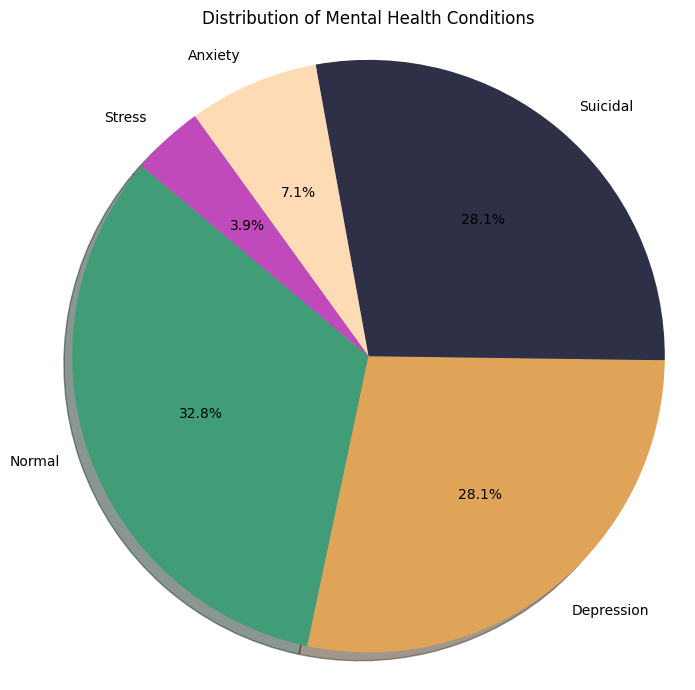

In [ ]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()


In [ ]:
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Obsesssion with Hepatitis C from manicures I'm a woman in her late 20s.  Now that I am talking with my husband about having a baby, I'm starting to worry that I could have hep c, and could pass it to my baby.  You might think "Easy, just get tested" but that would stress me out more than anything.  There are so many false positives, not to mention the fact that if the healthcare law changes, I could have a "preexisting condition" on my record.

My therapist doesn't think I should worry.  I am not a baby boomer, IV drug user, never had any blood transfusions, my only unprotected sex partner is my husband, etc...none of the major risk factors.  But I can't stop thinking about the few manicures I've gotten in my life.  I've only ever gotten about ten manicures at a salon, but I've read that this is a possible mode of transmission.  Of course the logic side of my brain tells me that most women get FAR more than 10 manis in their life, and most women do not have h

In [ ]:
# Calculate the number of characters and sentences
nltk.download('punkt_tab')
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


       num_of_characters  num_of_sentences
count       37938.000000      37938.000000
mean          560.938821          6.522062
std           821.690040          9.146409
min             2.000000          1.000000
25%            70.000000          1.000000
50%           309.500000          4.000000
75%           714.000000          8.000000
max         27390.000000        300.000000


In [ ]:
df[df['num_of_characters'] > 10000]

,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180
21396,will i ever be noticed? is my life worth anyth...,Depression,12298,160


In [ ]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)

df['statement']=df['original_statement'].str.lower()
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


In [ ]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


In [ ]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


In [ ]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


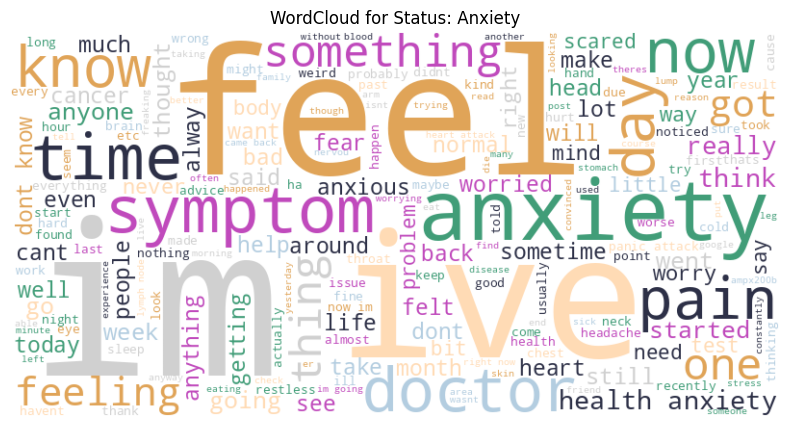

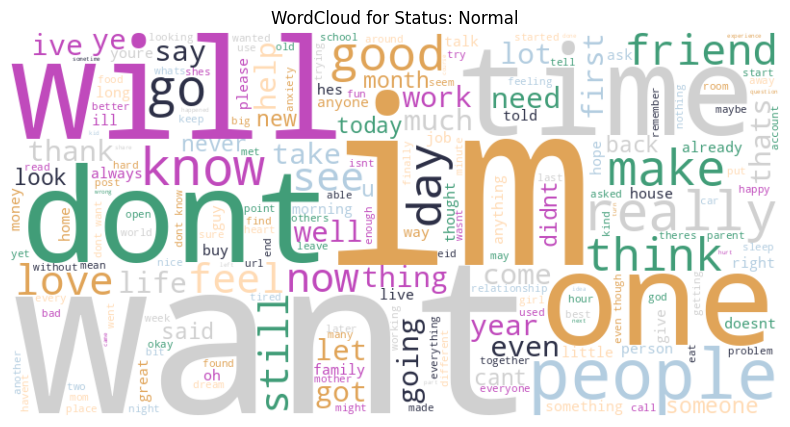

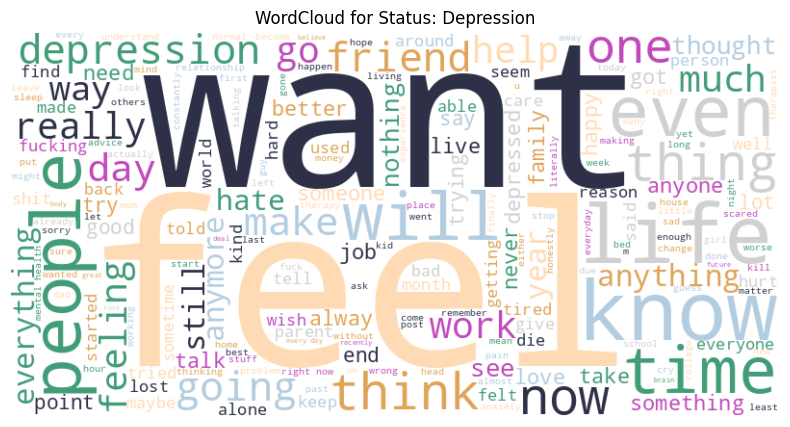

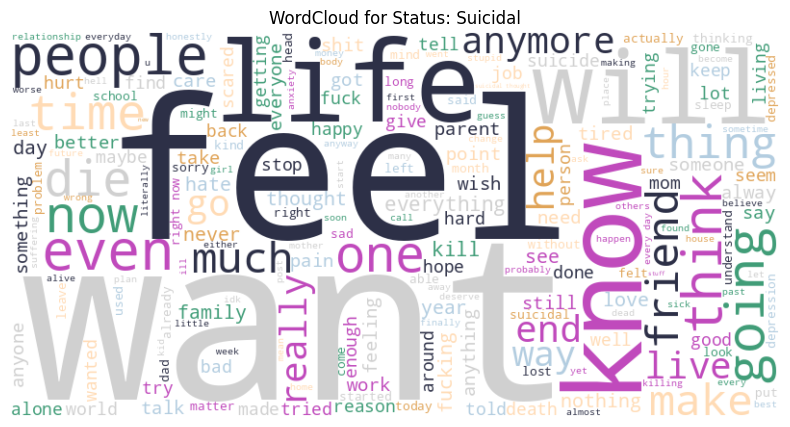

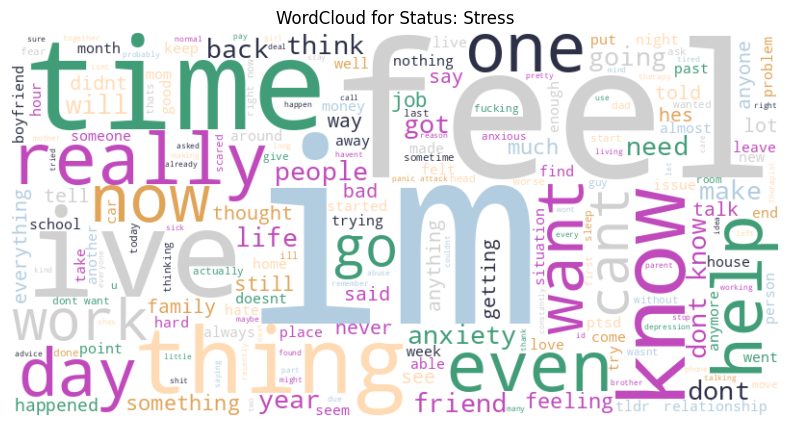

In [ ]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

In [ ]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

In [ ]:
from sklearn.preprocessing import LabelEncoder


lbl_enc = LabelEncoder()


y = lbl_enc.fit_transform(y)


print(y)

[0 0 0 ... 1 1 1]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [ ]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [ ]:
X_train_combined.shape

(30350, 50002)

In [ ]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

# Print the shape to confirm resampling
print(X_train_resampled.shape)


(49995, 50002)


In [ ]:
X_train_resampled.shape

(49995, 50002)

XGBoost Accuracy:  0.7853189246178176

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89       568
           1       0.73      0.70      0.71      2171
           2       0.92      0.91      0.91      2444
           3       0.56      0.84      0.67       301
           4       0.70      0.70      0.70      2104

    accuracy                           0.79      7588
   macro avg       0.76      0.80      0.78      7588
weighted avg       0.79      0.79      0.79      7588



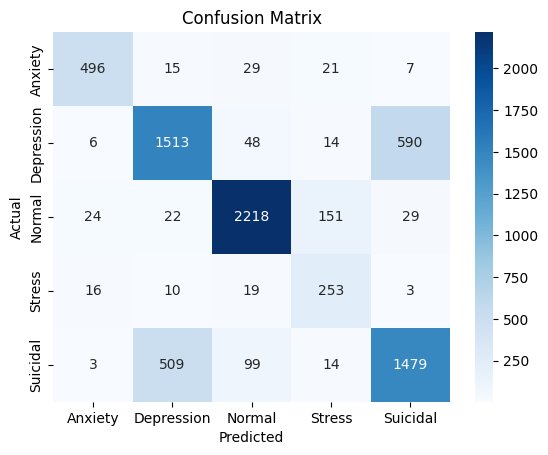

In [ ]:
# Importing necessary libraries
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
# Initialize XGBoost classifier
xgb_clf = XGBClassifier(random_state=101)

# Train the classifier
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_xgb = xgb_clf.predict(X_test_combined)

# Evaluate model performance
print("XGBoost Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix (optional, for additional performance insight)
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import re
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Assuming the vectorizer, label encoder, and XGBoost model are already defined and trained

# 1. Preprocess the input text (same steps as in training)
def preprocess_input(text):
    """
    Preprocess the input text in the same way as the training data.
    """
    def remove_patterns(text):
        text = re.sub(r'http[s]?://\S+', '', text)  # Remove URLs
        text = re.sub(r'\[.*?\]\(.*?\)', '', text)  # Remove markdown-style links
        text = re.sub(r'@\w+', '', text)  # Remove handles
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and other special characters
        return text.strip()

    # Step 1: Lowercase the text
    text = text.lower()

    # Step 2: Remove patterns (URLs, handles, etc.)
    text = remove_patterns(text)

    # Step 3: Tokenize the text
    tokens = word_tokenize(text)

    # Step 4: Stem the tokens
    stemmer = PorterStemmer()
    tokens_stemmed = ' '.join(stemmer.stem(str(token)) for token in tokens)

    return tokens_stemmed

# 2. Predicting function
def predict_new_input(input_text):
    # Step 1: Preprocess the new input
    processed_text = preprocess_input(input_text)

    # Step 2: Transform the processed text using the same TF-IDF vectorizer
    processed_tfidf = vectorizer.transform([processed_text])  # Transform into TF-IDF (list format)

    # Step 3: Extract numerical features (like number of characters and sentences)
    num_characters = len(input_text)
    num_sentences = len(nltk.sent_tokenize(input_text))
    numerical_features = np.array([[num_characters, num_sentences]])

    # Step 4: Combine the TF-IDF features with the numerical features
    input_combined = hstack([processed_tfidf, numerical_features])

    # Step 5: Make the prediction using the trained XGBoost model
    prediction = xgb_clf.predict(input_combined)

    # Step 6: Convert the predicted label back to its original category
    predicted_status = lbl_enc.inverse_transform(prediction)

    return predicted_status[0]

# Example usage
new_input = "I feel very overwhelmed and stressed out with my work."
predicted_status = predict_new_input(new_input)
print(f"Predicted Status: {predicted_status}")


Predicted Status: Normal


XGBoost Accuracy: 0.778663629460896

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       779
           1       0.85      0.86      0.86       573
           2       0.78      0.64      0.70      3020
           3       0.92      0.91      0.91      3281
           4       0.68      0.72      0.70       212
           5       0.51      0.76      0.61       489
           6       0.65      0.73      0.69      2182

    accuracy                           0.78     10536
   macro avg       0.74      0.78      0.76     10536
weighted avg       0.79      0.78      0.78     10536



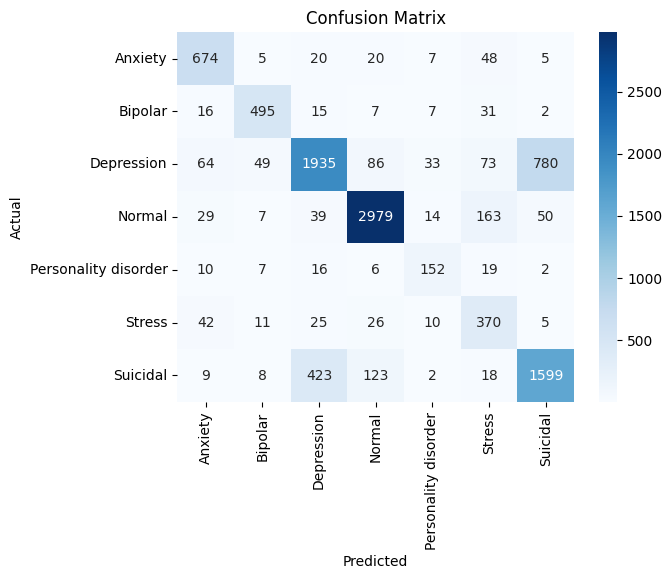

Predicted Status: Stress


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack
from xgboost import XGBClassifier

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('/content/Mental_Health/mental_health_data.csv', index_col=0)

# Data Cleaning
df.dropna(inplace=True)

def remove_patterns(text):
    text = re.sub(r'http[s]?://\S+', '', text)  # Remove URLs
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)  # Remove markdown links
    text = re.sub(r'@\w+', '', text)  # Remove handles
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    return text.strip()

df['statement'] = df['statement'].str.lower().apply(remove_patterns)

# Feature Engineering
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

def stem_tokens(tokens):
    stemmer = PorterStemmer()
    return ' '.join(stemmer.stem(token) for token in tokens)

df['tokens'] = df['statement'].apply(word_tokenize)
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

# Encode labels
lbl_enc = LabelEncoder()
df['status_encoded'] = lbl_enc.fit_transform(df['status'])

# Define features and labels
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status_encoded']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# Combine numerical features with TF-IDF features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

# Oversample the training data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

# Train the XGBoost model
xgb_clf = XGBClassifier(random_state=101)
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Predictions and Evaluation
y_pred_xgb = xgb_clf.predict(X_test_combined)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Preprocessing for new inputs
def preprocess_input(text):
    text = text.lower()
    text = remove_patterns(text)
    tokens = word_tokenize(text)
    stemmed_text = ' '.join(PorterStemmer().stem(token) for token in tokens)
    return stemmed_text

# Predict function
def predict_new_input(input_text):
    processed_text = preprocess_input(input_text)
    processed_tfidf = vectorizer.transform([processed_text])
    num_characters = len(input_text)
    num_sentences = len(nltk.sent_tokenize(input_text))
    numerical_features = np.array([[num_characters, num_sentences]])
    input_combined = hstack([processed_tfidf, numerical_features])
    prediction = xgb_clf.predict(input_combined)
    predicted_status = lbl_enc.inverse_transform(prediction)
    return predicted_status[0]

# Test the prediction function
new_input = "I feel very overwhelmed and stressed out with my work."
print(f"Predicted Status: {predict_new_input(new_input)}")


In [ ]:
new_input = "I feel very overwhelmed and stressed out with my work."
print(f"Predicted Status: {predict_new_input(new_input)}")

Predicted Status: Stress


In [ ]:
new_input = "I can't stop worrying about everything, even the smallest things make me anxious"
print(f"Predicted Status: {predict_new_input(new_input)}")

Predicted Status: Anxiety


In [ ]:
new_input = "The sadness feels never-ending, and I don't know how to escape it."
print(f"Predicted Status: {predict_new_input(new_input)}")

Predicted Status: Normal


In [ ]:
new_input = "i am happy"
print(f"Predicted Status: {predict_new_input(new_input)}")


Predicted Status: Normal


In [ ]:
new_input = "I am sad today because i am not going to trip."
print(f"Predicted Status: {predict_new_input(new_input)}")


Predicted Status: Anxiety


In [ ]:
new_input = " i love eating"
print(f"Predicted Status: {predict_new_input(new_input)}")

Predicted Status: Normal


In [ ]:
new_input = "News revealed that he died by suicide yesterday. "
print(f"Predicted Status: {predict_new_input(new_input)}")


Predicted Status: Suicidal


In [ ]:
new_input = "she killed her dog "
print(f"Predicted Status: {predict_new_input(new_input)}")

Predicted Status: Normal
